In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from pandas import read_csv, DataFrame
from sklearn.preprocessing import MinMaxScaler
from PyEMD import CEEMDAN
from scipy.signal import hilbert

In [2]:
TNX = pd.read_csv(r"C:\Users\kayja\Documents\BlackRock_HackKnight\HackKnight\10yrs_US_GOVT_BondYields\data\monthly_csv.csv")
y = TNX["Rate"].values.astype(float)

cIMF decomposition: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


ValueError: num must be an integer with 1 <= num <= 6, not 7

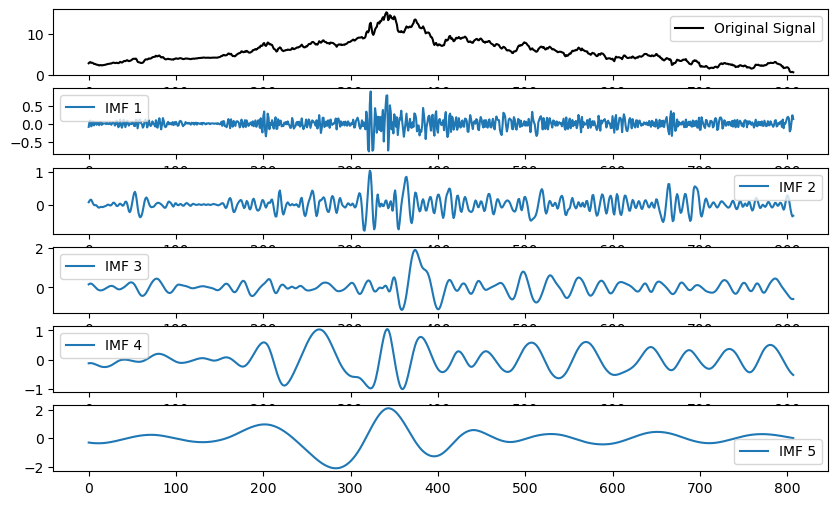

In [3]:
# Parameters for CEEMDAN
num_modes = 5
num_iterations = 100
noise_std = 0.2

# Perform CEEMDAN
ceemdan = CEEMDAN()
ceemdan.noise_seed(0)  # Set a seed for reproducibility
imfs = ceemdan.ceemdan(y, np.arange(1, 809).astype(float), num_modes, num_iterations)

# Plot the original signal and IMFs
plt.figure(figsize=(10, 6))
plt.subplot(num_modes + 1, 1, 1)
plt.plot(y, color='black', label='Original Signal')
plt.legend()

for i, imf in enumerate(imfs):
    plt.subplot(num_modes + 1, 1, i + 2)
    plt.plot(imf, label=f'IMF {i + 1}')
    plt.legend()

plt.tight_layout()
plt.show()

C:\Users\kayja\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


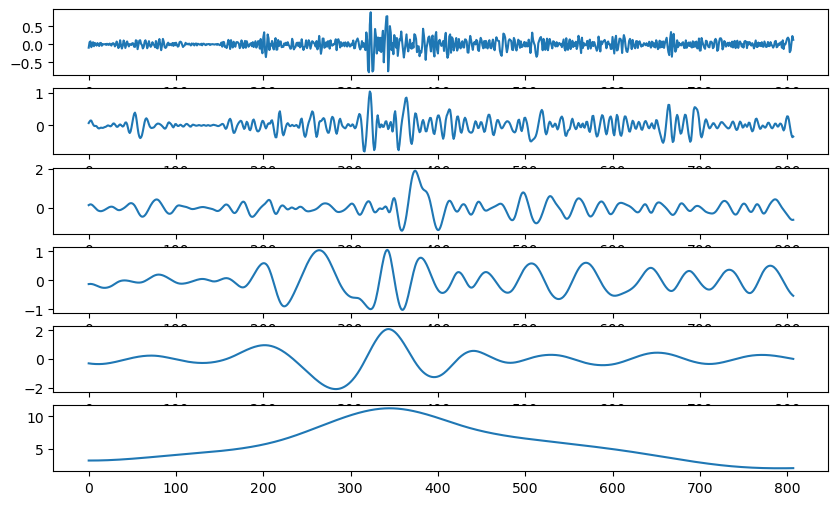

In [4]:
imf_hilb_0 = hilbert(imfs[0, :])
imf_hilb_1 = hilbert(imfs[1, :])
imf_hilb_2 = hilbert(imfs[2, :])
imf_hilb_3 = hilbert(imfs[3, :])
imf_hilb_4 = hilbert(imfs[4, :])
imf_hilb_5 = hilbert(imfs[5, :])

plt.figure(figsize = (10, 6))
plt.subplot(6, 1, 1)
plt.plot(imf_hilb_0)

plt.subplot(6, 1, 2)
plt.plot(imf_hilb_1)

plt.subplot(6, 1, 3)
plt.plot(imf_hilb_2)

plt.subplot(6, 1, 4)
plt.plot(imf_hilb_3)

plt.subplot(6, 1, 5)
plt.plot(imf_hilb_4)

plt.subplot(6, 1, 6)
plt.plot(imf_hilb_5)

In [5]:
type(imfs)
imfs = np.transpose(imfs)
imfs.shape

(808, 6)

In [6]:
def normalize(df):
    """
        Uses minMax scaler on data to normalize. Important especially for Volume and google_lvl
        @param df: data frame with all features
    """
    df = DataFrame(df)
    df.dropna(inplace = True)
    df = df.values
    df = df.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    norm = scaler.fit_transform(df)
    return scaler, norm


scaler, normalized_data = normalize(imfs)

train_size = int(len(normalized_data) * 0.9)
test_size = len(normalized_data) - train_size
train, test = normalized_data[:train_size], normalized_data[train_size:]

def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

class lstmModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=6, hidden_size=100, num_layers=1, batch_first=True)
        self.linear1 = nn.Linear(100, 6)
        self.lstm2 = nn.LSTM(input_size=6, hidden_size=200, num_layers=1, batch_first=True)
        self.linear2 = nn.Linear(200, 6)
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.linear1(x)
        x, _ = self.lstm2(x)
        x = self.linear2(x)
        return x

C:\Users\kayja\AppData\Local\Temp\ipykernel_8932\2425126935.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


In [7]:
model = lstmModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(normalized_data) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(normalized_data) * np.nan
    test_plot[train_size+lookback:len(normalized_data)] = model(X_test)[:, -1, :]

Epoch 0: train RMSE 0.3053, test RMSE 0.2726
Epoch 10: train RMSE 0.1032, test RMSE 0.0715
Epoch 20: train RMSE 0.0955, test RMSE 0.0607


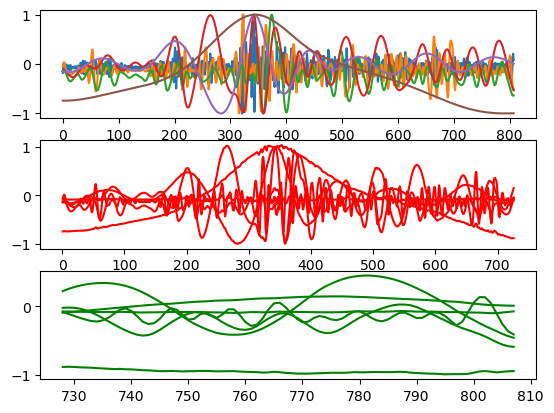

In [8]:
plt.subplot(3, 1, 1)
plt.plot(normalized_data)
plt.subplot(3, 1, 2)
plt.plot(train_plot, c='r')
plt.subplot(3, 1, 3)
plt.plot(test_plot, c='g')
plt.show()

In [9]:
torch.save(model, r"C:\Users\kayja\Documents\BlackRock_HackKnight\HackKnight\tnx_model.pkl")

In [10]:
model1 = torch.load(r"C:\Users\kayja\Documents\BlackRock_HackKnight\HackKnight\tnx_model.pkl")
output = model1(y_test[-1, :, :])

show_output = float(torch.sum(output)*-0.24)
show_output

0.5982142090797424